# License plate detection and recognition(YOLOv3+CNN+OpenCV)
* 環境
    - python=3.5
    - tensorflow-gpu=1.6.0
    - keras=2.1.5
    - opencv-python=4.20
    
* 流程
    1. CNN對英文字母、數字做訓練(on Colaboratory)。 用來辨認(recognition)
    2. YOLOv3對汽車圖片做訓練(on Colaboratory)。    用來偵測(detection)
        - [qqwweee/keras-yolo3](https://github.com/qqwweee/keras-yolo3)
        - 資料集
        - labelImg
        - class.txt
        - 劃分train, test
        - 將train, test.txt轉為yolo格式(VOC)
        - 轉換pretrained weights為適合keras的模型文件h5 (cfg的設定在這裡改)
        - 用kmeans計算train資料集anchor位置
        - 修改train.py(依個人位置設定)(annotation_path, classes_path, weights_path, log_dir, betch_size, input_size)
    3. 載入YOLOv3模型辨認車牌位置後，用OpenCV將車牌的字做字符分割，分割後用CNN訓練完的模型辨認字母。

# CNN對英文字母、數字做訓練(Colaboratory)

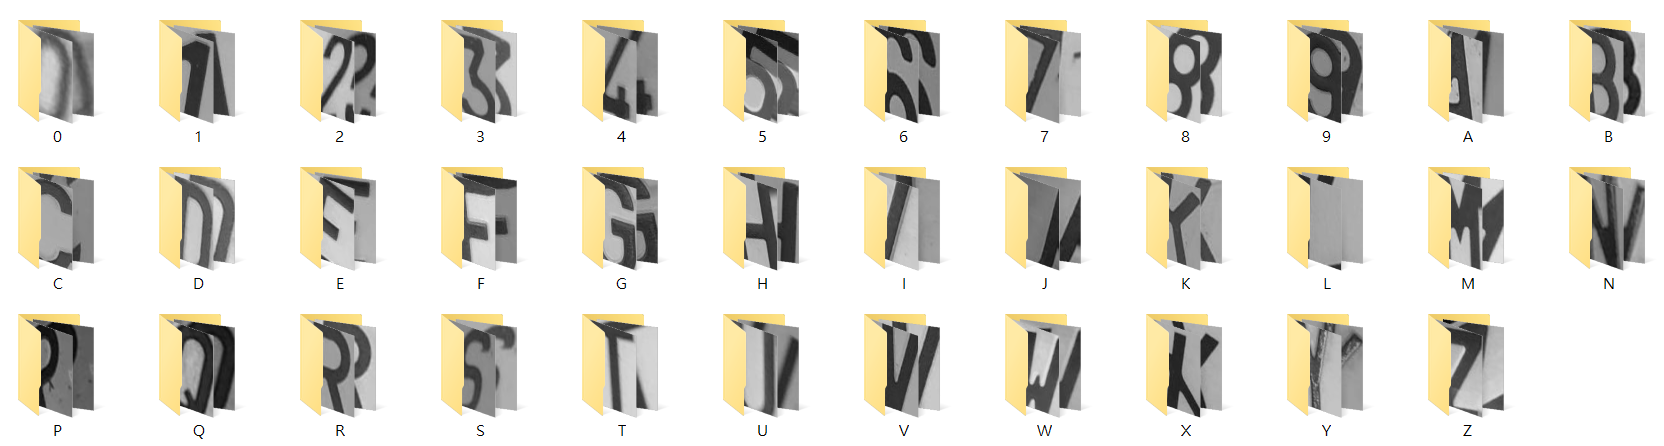
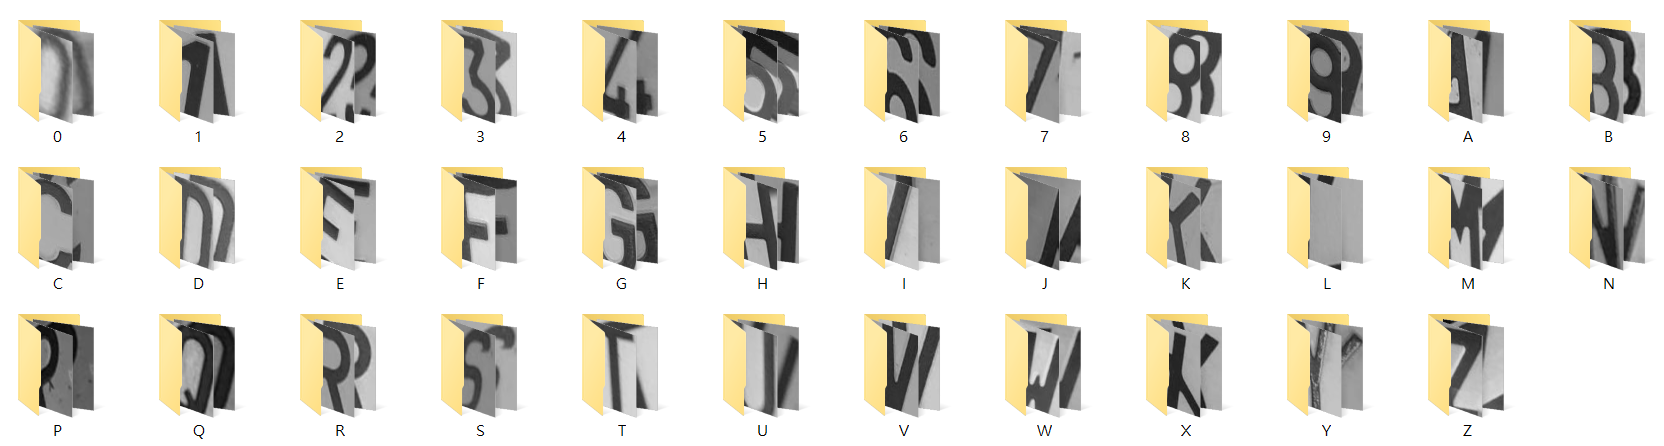

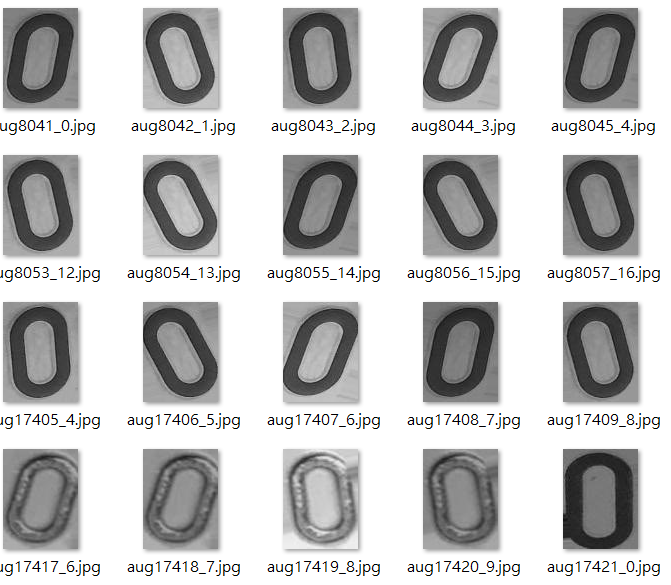

In [ ]:
# Colaboratory 配置
# 將google drive載入colab
from google.colab import drive
drive.mount('/content/drive')

# 更新工作目錄
import os
print(os.getcwd())
os.chdir("/content/drive/My Drive/code/yolo/yolo3-qqwweee/")

# 降低版本
%tensorflow_version 1.x
!pip install keras==2.1.5

In [ ]:
import cv2
import os.path
import numpy as np
import glob
from imutils import paths
from PIL import Image
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten, Dense
# 輸入圖片大小
width = 75
height = 100
channel = 1 # 灰階

imagedir  = "letter_dataset" # 訓練資料
modelname = "letter.hdf5"    # 模型名稱

# 讀取資料 (超慢)
'''
data = []  # 資料串列
labels =[] # 標籤串列
for image_file in paths.list_images(imagedir):
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #轉灰階
    label = image_file.split(os.path.sep)[-2] #擷取文字資料夾名稱
    data.append(image)   # 加入圖形
    labels.append(label) # 加入標籤
data  = np.array(data)
label = np.array(labels)
'''
# 讀取資料 (比較快)
def load_data():
    images = np.array([]).reshape(0,height,width) #空array
    labels = np.array([])                         #空array
    directories = [x[0] for x in os.walk('letter_dataset')][1:]
    print(directories)
    for directory in directories:
        filelist = glob.glob(directory+'/*.jpg')
        sub_images = np.array([np.array(Image.open(fname)) for fname in filelist])
        if directory[-1:].isdigit():
            sub_labels = [int(directory[-1:])]*len(sub_images)
        else:
            sub_labels = [directory[-1:]] * len(sub_images)
        images = np.append(images,sub_images, axis = 0)
        labels = np.append(labels,sub_labels, axis = 0)
    # 訓練資料佔80%，測試資料佔20%
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, shuffle=True)
    return (X_train, y_train), (X_test, y_test)

(train_images, train_labels), (test_images, test_labels) = load_data()
# 將輸入圖片的array維度改成一維 之後輸入CNN
train_images = train_images.reshape((train_images.shape[0], height, width, channel))
test_images = test_images.reshape((test_images.shape[0], height, width,channel))
# 正規化
train_images, test_images = train_images / 255.0, test_images / 255.0

# 轉換標籤one-hot
lb = LabelBinarizer().fit(train_labels)
train_labels = lb.transform(train_labels)
test_labels  = lb.transform(test_labels)

# 建立模型
model = Sequential()
# 神經網路
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same',
        input_shape=(height, width, channel), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(5,5), padding='same',
        activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(5,5), padding='same',activation="relu"))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(35, activation="softmax")) #35類
model.summary()
model.compile(optimizer='adam',
            loss='categorical_crossentropy', # sparse_categorical_crossentropy
            metrics=['accuracy'])
#verbose=1輸出進度條紀錄
model.fit(train_images, train_labels, validation_split=0.2, epochs=8, verbose=1)

#準確率
test_loss, test_acc  = model.evaluate(test_images, test_labels)
print(test_acc)
#儲存模型
model.save('model_data/'+ modelname)

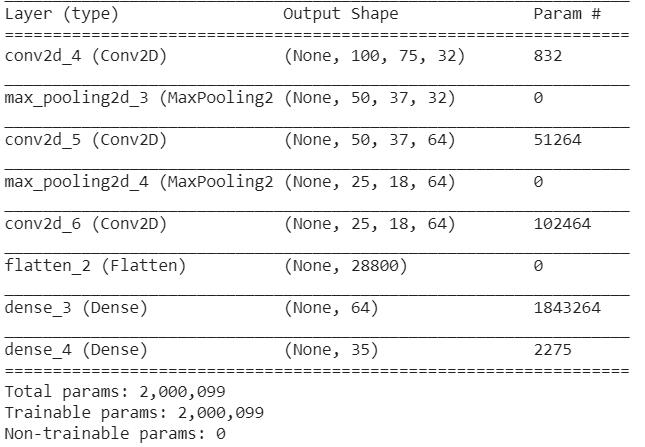

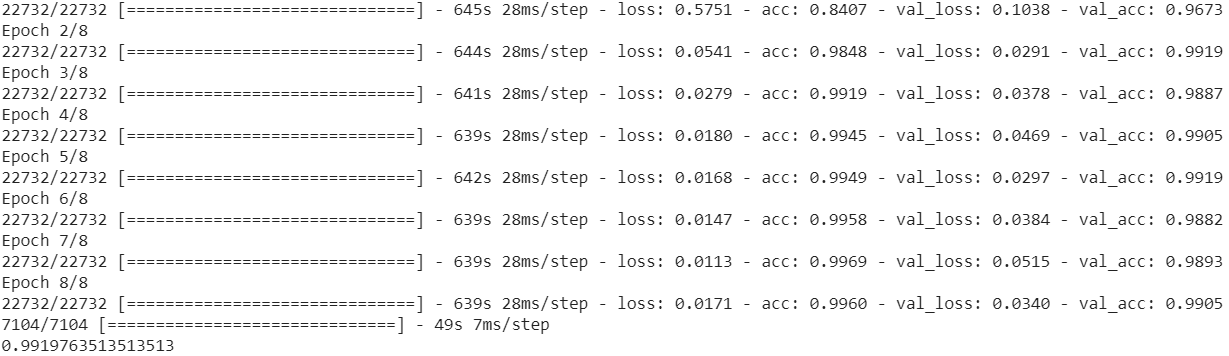

# YOLOv3對汽車圖片做訓練(Colaboratory)

In [ ]:
# Colaboratory 配置
# 將google drive載入colab
from google.colab import drive
drive.mount('/content/drive')

# 更新工作目錄
import os
print(os.getcwd())
os.chdir("/content/drive/My Drive/code/yolo/yolo3-qqwweee/")

# 降低版本
%tensorflow_version 1.x
!pip install keras==2.1.5

In [ ]:
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

# 限制記憶體使用量
#import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
#os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

def _main():
    annotation_path = '2007_train.txt'
    log_dir = 'logs/000/'
    classes_path = 'model_data/my_classes.txt'
    anchors_path = 'model_data/yolo_anchors.txt'
    class_names = get_classes(classes_path)
    num_classes = len(class_names)
    anchors = get_anchors(anchors_path)

    input_shape = (416,416) # multiple of 32, hw

    is_tiny_version = len(anchors)==6 # default setting
    if is_tiny_version:
        model = create_tiny_model(input_shape, anchors, num_classes,
            freeze_body=2, weights_path='model_data/1.h5')
    else:
        model = create_model(input_shape, anchors, num_classes,
            freeze_body=2, weights_path='model_data/0.h5') # make sure you know what you freeze

    logging = TensorBoard(log_dir=log_dir)
    checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
        monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=60, verbose=1)

    val_split = 0.1
    with open(annotation_path) as f:
        lines = f.readlines()
    np.random.seed(10101)
    np.random.shuffle(lines)
    np.random.seed(None)
    num_val = int(len(lines)*val_split)
    num_train = len(lines) - num_val

    # Train with frozen layers first, to get a stable loss.
    # Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
    if True:
        model.compile(optimizer=Adam(lr=1e-5), loss={ # lr=1e-3
            # use custom yolo_loss Lambda layer.
            'yolo_loss': lambda y_true, y_pred: y_pred})

        batch_size =1
        print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
        model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
                steps_per_epoch=max(1, num_train//batch_size),
                validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
                validation_steps=max(1, num_val//batch_size),
                epochs=30,
                initial_epoch=0,
                callbacks=[logging, checkpoint])
        model.save_weights(log_dir + 'trained_weights_stage_1.h5')

    # Unfreeze and continue training, to fine-tune.
    # Train longer if the result is not good.
    if True:
        for i in range(len(model.layers)):
            model.layers[i].trainable = True
        model.compile(optimizer=Adam(lr=1e-6), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
        print('Unfreeze all of the layers.')

        batch_size = 1 # note that more GPU memory is required after unfreezing the body
        print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
        model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=60,
            initial_epoch=30,
            callbacks=[logging, checkpoint, reduce_lr, early_stopping])
        model.save_weights(log_dir + 'trained_weights_final.h5')

    # Further training if needed.


def get_classes(classes_path):
    '''loads the classes'''
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def get_anchors(anchors_path):
    '''loads the anchors from a file'''
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape(-1, 2)


def create_model(input_shape, anchors, num_classes, load_pretrained=True, freeze_body=2,
            weights_path='model_data/yolo_weights.h5'):
    '''create the training model'''
    K.clear_session() # get a new session
    image_input = Input(shape=(None, None, 3))
    h, w = input_shape
    num_anchors = len(anchors)

    y_true = [Input(shape=(h//{0:32, 1:16, 2:8}[l], w//{0:32, 1:16, 2:8}[l], \
        num_anchors//3, num_classes+5)) for l in range(3)]

    model_body = yolo_body(image_input, num_anchors//3, num_classes)
    print('Create YOLOv3 model with {} anchors and {} classes.'.format(num_anchors, num_classes))

    if load_pretrained:
        model_body.load_weights(weights_path, by_name=True, skip_mismatch=True)
        print('Load weights {}.'.format(weights_path))
        if freeze_body in [1, 2]:
            # Freeze darknet53 body or freeze all but 3 output layers.
            num = (185, len(model_body.layers)-3)[freeze_body-1]
            for i in range(num): model_body.layers[i].trainable = False
            print('Freeze the first {} layers of total {} layers.'.format(num, len(model_body.layers)))

    model_loss = Lambda(yolo_loss, output_shape=(1,), name='yolo_loss',
        arguments={'anchors': anchors, 'num_classes': num_classes, 'ignore_thresh': 0.5})(
        [*model_body.output, *y_true])
    model = Model([model_body.input, *y_true], model_loss)

    return model

def create_tiny_model(input_shape, anchors, num_classes, load_pretrained=True, freeze_body=2,
            weights_path='model_data/tiny_yolo_weights.h5'):
    '''create the training model, for Tiny YOLOv3'''
    K.clear_session() # get a new session
    image_input = Input(shape=(None, None, 3))
    h, w = input_shape
    num_anchors = len(anchors)

    y_true = [Input(shape=(h//{0:32, 1:16}[l], w//{0:32, 1:16}[l], \
        num_anchors//2, num_classes+5)) for l in range(2)]

    model_body = tiny_yolo_body(image_input, num_anchors//2, num_classes)
    print('Create Tiny YOLOv3 model with {} anchors and {} classes.'.format(num_anchors, num_classes))

    if load_pretrained:
        model_body.load_weights(weights_path, by_name=True, skip_mismatch=True)
        print('Load weights {}.'.format(weights_path))
        if freeze_body in [1, 2]:
            # Freeze the darknet body or freeze all but 2 output layers.
            num = (20, len(model_body.layers)-2)[freeze_body-1]
            for i in range(num): model_body.layers[i].trainable = False
            print('Freeze the first {} layers of total {} layers.'.format(num, len(model_body.layers)))

    model_loss = Lambda(yolo_loss, output_shape=(1,), name='yolo_loss',
        arguments={'anchors': anchors, 'num_classes': num_classes, 'ignore_thresh': 0.7})(
        [*model_body.output, *y_true])
    model = Model([model_body.input, *y_true], model_loss)

    return model

def data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes):
    '''data generator for fit_generator'''
    n = len(annotation_lines)
    i = 0
    while True:
        image_data = []
        box_data = []
        for b in range(batch_size):
            if i==0:
                np.random.shuffle(annotation_lines)
            image, box = get_random_data(annotation_lines[i], input_shape, random=True)
            image_data.append(image)
            box_data.append(box)
            i = (i+1) % n
        image_data = np.array(image_data)
        box_data = np.array(box_data)
        y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
        yield [image_data, *y_true], np.zeros(batch_size)

def data_generator_wrapper(annotation_lines, batch_size, input_shape, anchors, num_classes):
    n = len(annotation_lines)
    if n==0 or batch_size<=0: return None
    return data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes)

if __name__ == '__main__':
    _main()

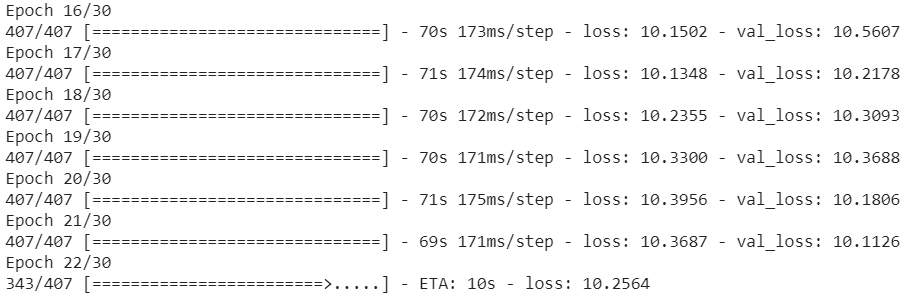

# 載入YOLOv3模型辨認車牌位置後，用OpenCV將車牌的字做字符分割，分割後用CNN訓練完的模型辨認字母

In [ ]:
# -*- coding: utf-8 -*-
"""
Class definition of YOLO_v3 style detection model on image and video
"""

import colorsys
import os
from timeit import default_timer as timer
import time
import numpy as np
import cv2
import shutil, os
import tensorflow as tf
from time import sleep
from keras import backend as K
from keras.models import load_model
from keras.layers import Input
from PIL import Image, ImageFont, ImageDraw

from yolo3.model import yolo_eval, yolo_body, tiny_yolo_body
from yolo3.utils import letterbox_image
from keras.utils import multi_gpu_model

# 限制記憶體使用量
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
#os.environ["CUDA_VISIBLE_DEVICES"]="0"

class YOLO(object):
    _defaults = {
        "model_path": 'logs/000/0.h5', #指定 YOLO 訓練完成權重檔路徑及名稱
        "anchors_path": 'model_data/yolo_anchors.txt', #指定錨點定義檔路徑及名稱
        "classes_path": 'model_data/my_classes.txt', #指定自定義標籤檔路徑及名稱
        "score" : 0.5,  #最低置信度門檻(0.01~0.99)
        "iou" : 0.45,   #重疊區比例(0.01~1.0)
        "model_image_size" : (416, 416),
        "gpu_num" : 1,  #使用GPU數量
    }

    @classmethod
    def get_defaults(cls, n):
        if n in cls._defaults:
            return cls._defaults[n]
        else:
            return "Unrecognized attribute name '" + n + "'"

    def __init__(self, **kwargs):
        self.__dict__.update(self._defaults) # set up default values
        self.__dict__.update(kwargs) # and update with user overrides
        self.class_names = self._get_class()
        self.anchors = self._get_anchors()
        self.sess = K.get_session()
        self.boxes, self.scores, self.classes = self.generate()

    def _get_class(self):
        classes_path = os.path.expanduser(self.classes_path)
        with open(classes_path) as f:
            class_names = f.readlines()
        class_names = [c.strip() for c in class_names]
        return class_names

    def _get_anchors(self):
        anchors_path = os.path.expanduser(self.anchors_path)
        with open(anchors_path) as f:
            anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        return np.array(anchors).reshape(-1, 2)

    def generate(self):
        model_path = os.path.expanduser(self.model_path)
        assert model_path.endswith('.h5'), 'Keras model or weights must be a .h5 file.'

        # Load model, or construct model and load weights.
        num_anchors = len(self.anchors)
        num_classes = len(self.class_names)
        is_tiny_version = num_anchors==6 # default setting
        try:
            self.yolo_model = load_model(model_path, compile=False)
        except:
            self.yolo_model = tiny_yolo_body(Input(shape=(None,None,3)), num_anchors//2, num_classes) \
                if is_tiny_version else yolo_body(Input(shape=(None,None,3)), num_anchors//3, num_classes)
            self.yolo_model.load_weights(self.model_path) # make sure model, anchors and classes match
        else:
            assert self.yolo_model.layers[-1].output_shape[-1] == \
                num_anchors/len(self.yolo_model.output) * (num_classes + 5), \
                'Mismatch between model and given anchor and class sizes'

        print('{} model, anchors, and classes loaded.'.format(model_path))

        # Generate colors for drawing bounding boxes.
        hsv_tuples = [(x / len(self.class_names), 1., 1.)
                      for x in range(len(self.class_names))]
        self.colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
        self.colors = list(
            map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
                self.colors))
        np.random.seed(10101)  # Fixed seed for consistent colors across runs.
        np.random.shuffle(self.colors)  # Shuffle colors to decorrelate adjacent classes.
        np.random.seed(None)  # Reset seed to default.

        # Generate output tensor targets for filtered bounding boxes.
        self.input_image_shape = K.placeholder(shape=(2, ))
        if self.gpu_num>=2:
            self.yolo_model = multi_gpu_model(self.yolo_model, gpus=self.gpu_num)
        boxes, scores, classes = yolo_eval(self.yolo_model.output, self.anchors,
                len(self.class_names), self.input_image_shape,
                score_threshold=self.score, iou_threshold=self.iou)
        return boxes, scores, classes

    def iou_fetch(self, image):
        if self.model_image_size != (None, None):
            assert self.model_image_size[0]%32 == 0, 'Multiples of 32 required'
            assert self.model_image_size[1]%32 == 0, 'Multiples of 32 required'
            boxed_image = letterbox_image(image, tuple(reversed(self.model_image_size)))
        else:
            new_image_size = (image.width - (image.width % 32),
                              image.height - (image.height % 32))
            boxed_image = letterbox_image(image, new_image_size)
        image_data = np.array(boxed_image, dtype='float32')

        image_data /= 255.
        image_data = np.expand_dims(image_data, 0)  # Add batch dimension.

        out_boxes, out_scores, out_classes = self.sess.run(
            [self.boxes, self.scores, self.classes],
            feed_dict={
                self.yolo_model.input: image_data,
                self.input_image_shape: [image.size[1], image.size[0]],
                K.learning_phase(): 0
            })
        #count = 0
        for i, c in reversed(list(enumerate(out_classes))):
            predicted_class = self.class_names[c]
            box = out_boxes[i]
            score = out_scores[i]

            label = '{} {:.2f}'.format(predicted_class, score)
        return score

    def output_iou(self, test_path = '2007_test.txt'):
        #yolo=YOLO()
        test_path = '2007_test.txt'
        iou_output = 'iou.txt'
        open(iou_output,'w')
        f = open(iou_output,'a')
        with open(test_path, 'r', encoding='UTF-8') as f1:
            lines = f1.readlines()
            for line in lines:
                count = line.count(' ') # 1個空白表示1個ground_truth位置
                image_path = line.split(' ', count)[0] # 擷取所有圖片位置
                image = Image.open(image_path)
                iou_score = str(yolo.iou_fetch(image))+'\n'
                f.write(iou_score)
        return None


    def detect_image(self, image):
        start = timer()

        if self.model_image_size != (None, None):
            assert self.model_image_size[0]%32 == 0, 'Multiples of 32 required'
            assert self.model_image_size[1]%32 == 0, 'Multiples of 32 required'
            boxed_image = letterbox_image(image, tuple(reversed(self.model_image_size)))
        else:
            new_image_size = (image.width - (image.width % 32),
                              image.height - (image.height % 32))
            boxed_image = letterbox_image(image, new_image_size)
        image_data = np.array(boxed_image, dtype='float32')

        print(image_data.shape)
        image_data /= 255.
        image_data = np.expand_dims(image_data, 0)  # Add batch dimension.

        out_boxes, out_scores, out_classes = self.sess.run(
            [self.boxes, self.scores, self.classes],
            feed_dict={
                self.yolo_model.input: image_data,
                self.input_image_shape: [image.size[1], image.size[0]],
                K.learning_phase(): 0
            })

        print('Found {} boxes for {}'.format(len(out_boxes), 'img'))

        font = ImageFont.truetype(font='font/FiraMono-Medium.otf',
                    size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
        thickness = (image.size[0] + image.size[1]) // 300

        for i, c in reversed(list(enumerate(out_classes))):
            predicted_class = self.class_names[c]
            box = out_boxes[i]
            score = out_scores[i]

            label = '{} {:.2f}'.format(predicted_class, score)
            draw = ImageDraw.Draw(image)
            label_size = draw.textsize(label, font)

            top, left, bottom, right = box
            top = max(0, np.floor(top + 0.5).astype('int32'))
            left = max(0, np.floor(left + 0.5).astype('int32'))
            bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
            right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
            print(label, (left, top), (right, bottom))

            if top - label_size[1] >= 0:
                text_origin = np.array([left, top - label_size[1]])
            else:
                text_origin = np.array([left, top + 1])

            for i in range(thickness):
                draw.rectangle(
                    [left + i, top + i, right - i, bottom - i],
                    outline=self.colors[c])
            draw.rectangle(
                [tuple(text_origin), tuple(text_origin + label_size)],
                fill=self.colors[c])
            draw.text(text_origin, label, fill=(0, 0, 0), font=font)
            del draw
            # 預測box的位置 firstCropImg
            prid_box_location = ((left, top), (right, bottom))
        end = timer()
        print(end - start)
        return image, prid_box_location

    def close_session(self):
        self.sess.close()

def detect_video(yolo, video_path, output_path=""):
    import cv2
    vid = cv2.VideoCapture(video_path)
    if not vid.isOpened():
        raise IOError("Couldn't open webcam or video")
    video_FourCC    = int(vid.get(cv2.CAP_PROP_FOURCC))
    video_fps       = vid.get(cv2.CAP_PROP_FPS)
    video_size      = (int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)),
                        int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    isOutput = True if output_path != "" else False
    if isOutput:
        print("!!! TYPE:", type(output_path), type(video_FourCC), type(video_fps), type(video_size))
        out = cv2.VideoWriter(output_path, video_FourCC, video_fps, video_size)
    accum_time = 0
    curr_fps = 0
    fps = "FPS: ??"
    prev_time = timer()
    while True:
        return_value, frame = vid.read()
        image = Image.fromarray(frame)
        image = yolo.detect_image(image)
        result = np.asarray(image)
        curr_time = timer()
        exec_time = curr_time - prev_time
        prev_time = curr_time
        accum_time = accum_time + exec_time
        curr_fps = curr_fps + 1
        if accum_time > 1:
            accum_time = accum_time - 1
            fps = "FPS: " + str(curr_fps)
            curr_fps = 0
        cv2.putText(result, text=fps, org=(3, 15), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=0.50, color=(255, 0, 0), thickness=2)
        cv2.namedWindow("result", cv2.WINDOW_NORMAL)
        cv2.imshow("result", result)
        if isOutput:
            out.write(result)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    yolo.close_session()

# 這邊加入如何對車牌做數字、字母辨識

# 對從yolo偵測的車牌再做一次裁切，將多餘的部分移除
def min_prid_box(img): #secondCrop
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(gray,127,255,0)
    contours,_ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(c) for c in contours] # 計算各輪廓面積
    if(len(areas)!=0): #只要面積數量不為0
        max_index = np.argmax(areas) #最大面積
        cnt=contours[max_index]
        x,y,w,h = cv2.boundingRect(cnt)
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        secondCrop = img[y:y+h,x:x+w]
    else: 
        secondCrop = img
    return secondCrop

def auto_canny(image, sigma=0.33):
    # 計算灰階值的中位數
    v = np.median(image)
    # 使用中位數應用於Canny edge dectection
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
    # return the edged image
    return edged

def opencvReadPlate(img):
    charList=[]
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    thresh_inv = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,71,1)
    edges = auto_canny(thresh_inv)
    # RETR_EXTERNAL只會檢測最外圍輪廓  CHAIN_APPROX_SIMPLE僅保存輪廓的彎處
    ctrs, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    sorted_ctrs = sorted(ctrs, key=lambda ctrs: cv2.boundingRect(ctrs)[0])
    img_area = img.shape[0]*img.shape[1] #車牌面積

    for i, ctr in enumerate(sorted_ctrs):
        x, y, w, h = cv2.boundingRect(ctr)
        roi_area = w*h
        # 非極大抑制(NMS): 主要用於更精確定位某種特徵
        non_max_sup = roi_area/img_area

        if((non_max_sup >= 0.015) and (non_max_sup < 0.09)):
            # 在這條件之下的才是文字
            if ((h>1.2*w) and (3*w>=h)):
                char = img[y:y+h,x:x+w]
                charList.append(cnnCharRecognition(char))
                #cv2.rectangle(影像, 頂點座標, 對向頂點座標, 顏色, 線條寬度)
                cv2.rectangle(img,(x,y),( x + w, y + h ),(90,0,255),2)
    cv2.imshow('OpenCV character segmentation',img)
    licensePlate="".join(charList)
    return licensePlate

def cnnCharRecognition(img):
    dictionary = {0:'0', 1:'1', 2 :'2', 3:'3', 4:'4', 5:'5', 6:'6', 7:'7', 8:'8', 9:'9', 10:'A',
    11:'B', 12:'C', 13:'D', 14:'E', 15:'F', 16:'G', 17:'H', 18:'I', 19:'J', 20:'K',
    21:'L', 22:'M', 23:'N', 24:'P', 25:'Q', 26:'R', 27:'S', 28:'T', 29:'U',
    30:'V', 31:'W', 32:'X', 33:'Y', 34:'Z'}
    # img二值化
    blackAndWhiteChar=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 將圖片大小縮放(差值法)成75*100 (根據訓練資料的圖片而定)
    blackAndWhiteChar = cv2.resize(blackAndWhiteChar,(75,100))
    # 將圖片的維度重組成1維資料輸入CNN做預測
    image = blackAndWhiteChar.reshape((1, 100,75, 1))
    # 正規化0~1 (加速收斂)
    image = image / 255.0
    new_predictions = characterRecognition.predict(image)
    char = np.argmax(new_predictions)
    return dictionary[char]

if __name__ == '__main__':
    # True:輸出2007_test.txt的iou.txt
    iou_txt = False
    if iou_txt:
        yolo = YOLO()
        yolo.output_iou()

    #Accuracy
    yolo = YOLO()
    count = 0
    with open('iou.txt', 'r', encoding='UTF-8') as f:
        lines = f.readlines()
        for line in lines:
            line = float(line)
            if line > float(yolo.score):
                count += 1 
    # 讀取2007_test.txt中每一列資料的 ground_truth位置
    ground_truth_num = 0
    with open('2007_test.txt', 'r', encoding='UTF-8') as f1:
        lines = f1.readlines()
        for line in lines:
            gt_count = line.count(' ') # 1個空白表示1個ground_truth位置
            ground_truth_num += gt_count
    Accuracy = count / ground_truth_num
    print('Accuracy: %.2f %%' %(Accuracy*100))

    licensePlate = []
    #載入CNN對數字、字母訓練完的模型
    characterRecognition = tf.keras.models.load_model('model_data/letter.hdf5')
    #path = 'D:\\3rd-ML100Days\\homework\\yolo3-qqwweee\\VOCdevkit\\VOC2007\\JPEGImages\\plates\\m502_2.jpg'
    path = 'D:\\3rd-ML100Days\\homework\\yolo3-qqwweee\\VOCdevkit\\VOC2007\\JPEGImages\\plates\\m546_0.jpg'
    
    # 顯示原圖經過辨識後車牌的位置(prid_box_location)與其label, confidence
    try:
        image = Image.open(path)
    except:
        print('Open image error! Check the image path.')
    r_image, prid_box_location = yolo.detect_image(image)
    r_image.show()
    # 取得box位置
    ((left, top), (right, bottom)) = prid_box_location

    # 用cv2.imread讀取圖片裁剪出車牌位置再用opencv做字符分割，最後經CNN模型分析字母
    image_cv = cv2.imread(path)
    # 用box位置對圖片裁減
    prid_box_image = image_cv[top:bottom, left:right]
    prid_box_image_min = min_prid_box(prid_box_image)
    #prid_box_image_min = min_prid_box(image_cv)


    cv2.imshow('prid_box_image', prid_box_image)
    cv2.imshow('prid_box_image_min', prid_box_image_min)
    cv2.waitKey(0)
    prid_box_image_min_Copy = prid_box_image_min.copy()
    licensePlate.append(opencvReadPlate(prid_box_image_min))
    print("Yolov3 + OpenCV + CNN : " + licencsePlate[0])
    cv2.waitKey(0)

    yolo.close_session()


'''
單張圖片顯示label、confidence
if __name__ == '__main__':
    yolo=YOLO()
    path = 'D:\\3rd-ML100Days\\homework\\yolo3-qqwweee\\VOCdevkit\\VOC2007\\JPEGImages\\plates\\m636_1.jpg'
    try:
        image = Image.open(path)
    except:
        print('Open Error! Try again!')
    else:
        #r_image, _ = yolo.detect_image(image)
        r_image = yolo.detect_image(image)
        r_image.show()

    yolo.close_session()
'''

'''
    # 讀取2007_test.txt中每一列資料的 ground_truth位置
    test_path = '2007_test.txt'
    ground_truth_num = 0
    with open(test_path, 'r', encoding='UTF-8') as f1:
        lines = f1.readlines()
        for line in lines:
            count = line.count(' ') # 1個空白表示1個ground_truth位置
            #line = line.split(' ', count)[1:] #line = line[1]
            #line_len = len(line)
            ground_truth_num += count
        print(ground_truth_num)

    # 取出iou測試
    yolo = YOLO()
    image_path = 'D:\\3rd-ML100Days\\homework\\yolo3-qqwweee\\VOCdevkit\\VOC2007\\JPEGImages\\plates\\m636_1.jpg'
    image = Image.open(image_path)
    yolo.iou_fetch(image)
'''

'''
    yolo=YOLO()
    test_path = '2007_test.txt'
    iou_output = 'iou.txt'

    open(iou_output,'w')
    f = open(iou_output,'a')
    with open(test_path, 'r', encoding='UTF-8') as f1:
        lines = f1.readlines()
        for line in lines:
            count = line.count(' ') # 1個空白表示1個ground_truth位置
            image_path = line.split(' ', count)[0] # 擷取所有圖片位置
            image = Image.open(image_path)
            iou_score = str(yolo.iou_fetch(image))+'\n'
            f.write(iou_score)
'''

'''
from keras.models import load_model
from PIL import Image
import numpy as py
import cv2
import shutil, os
from time import sleep

labels = ['0','1','2','3','4','5','6','7','8','9',
        'A','B','C','D','E','F','G','H','I','J','K',
        'L','M','N','P','Q','R','S','T','U','V','W',
        'X','Y','Z'] #標籤值
#擷取車牌
'''

'''
    licensePlate = []
    #載入CNN對數字、字母訓練完的模型
    characterRecognition = tf.keras.models.load_model('model_data/letter.hdf5')
    #單張圖片顯示label、confidence、測試集的Accuracy
    path = 'D:\\3rd-ML100Days\\homework\\yolo3-qqwweee\\VOCdevkit\\VOC2007\\JPEGImages\\plates\\m3_0.jpg'
    try:
        image = Image.open(path)
    except:
        print('Open image error! Check the image path.')
    #try:
    r_image, prid_box_location = yolo.detect_image(image)
    ((left, top), (right, bottom)) = prid_box_location
    # 裁切出圖片中license plate的位置  img[y:y+h, x:x+w]
    image_cv = cv2.imread(path)
    prid_box_image = image_cv[top:bottom, left:right]
    #prid_box_image = image.crop((left, top, right-left, bottom-top))
    prid_box_image_min = yolo.min_prid_box(prid_box_image)
    r_image.show()
    cv2.imshow('prid_box_image', prid_box_image)
    cv2.imshow('min_prid_box', prid_box_image_min)
    cv2.waitKey(0)
    prid_box_image_min_Copy = prid_box_image_min.copy()
    licensePlate.append(yolo.opencvReadPlate(prid_box_image_min, characterRecognition))
    print("Yolov3 + OpenCV + CNN : " + licensePlate[0])
    #except:
        #print('licensePlate Detection error!')
    cv2.waitKey(0)
'''

Accuracy of license plate detection : 100.00 %   

Accuracy = (IOU > 0.5) / num of ground truth

    Found 1 boxes for img   : 找到一個IOU>0.5的bounding box(label=plate)
    plate 1.00              : label=plate  connfidence=1.0=IOU*probability
    (713, 1375) (2227, 1952):bounding box的位置(左上, 右下)
    3.2301174               :運行花費秒數
    Yolov3 + OpenCV + CNN : 1WFW877 :車牌辨識結果為1WFW877

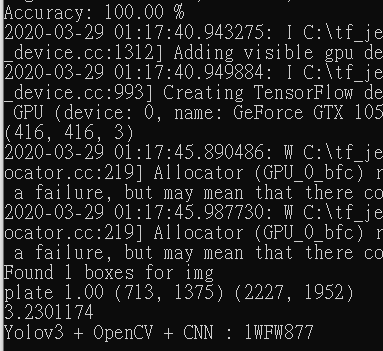

Result of License plate detection

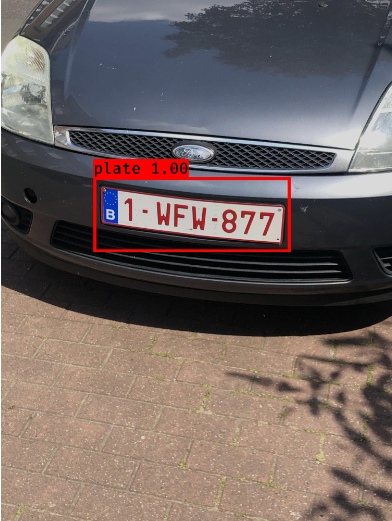

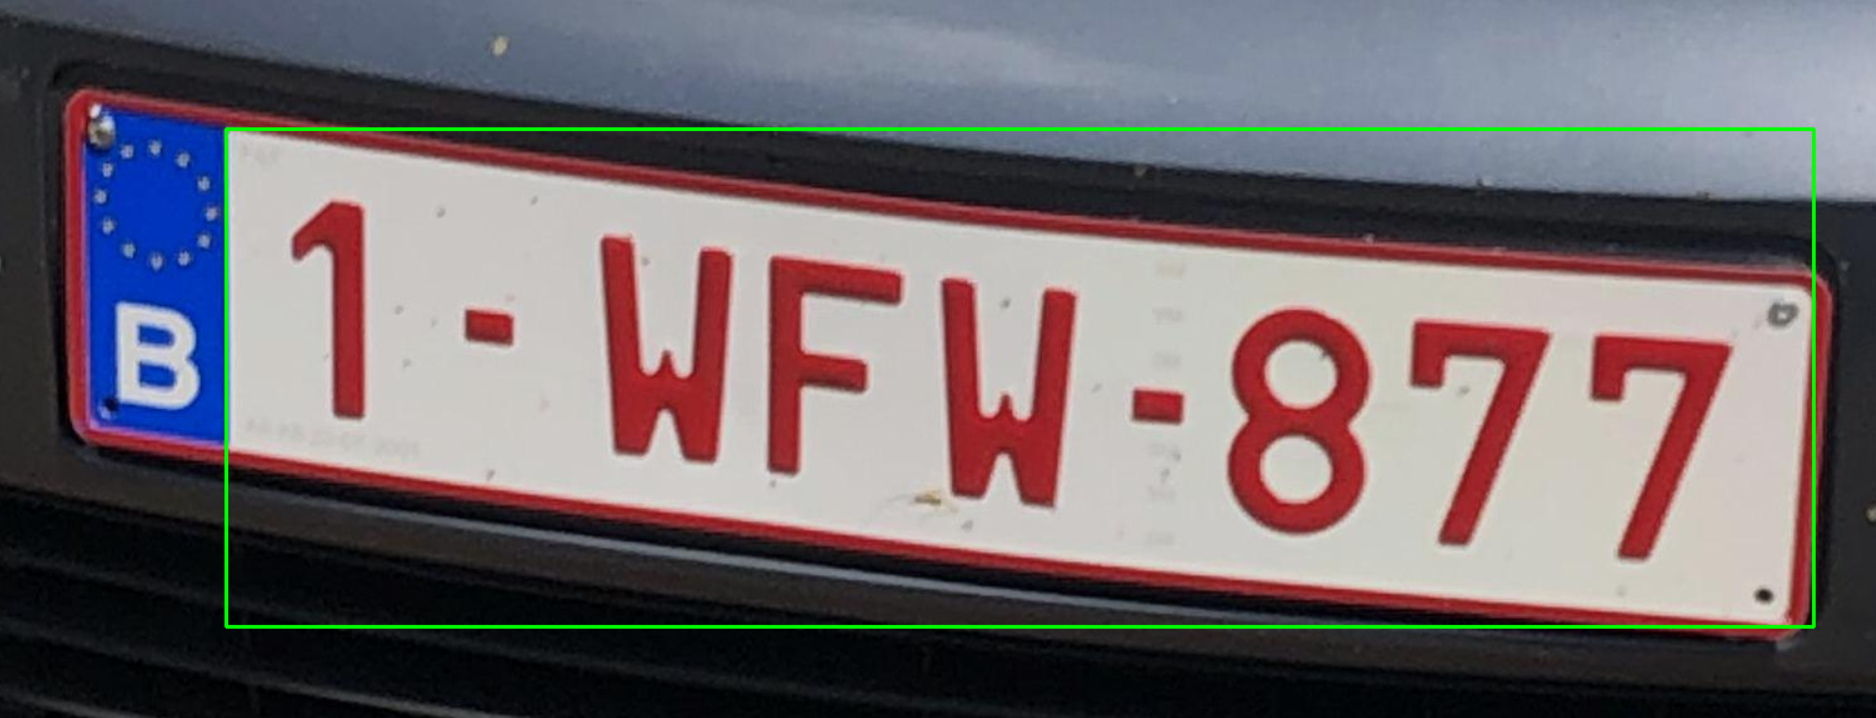

經過OpenCV車牌之外的範圍截掉

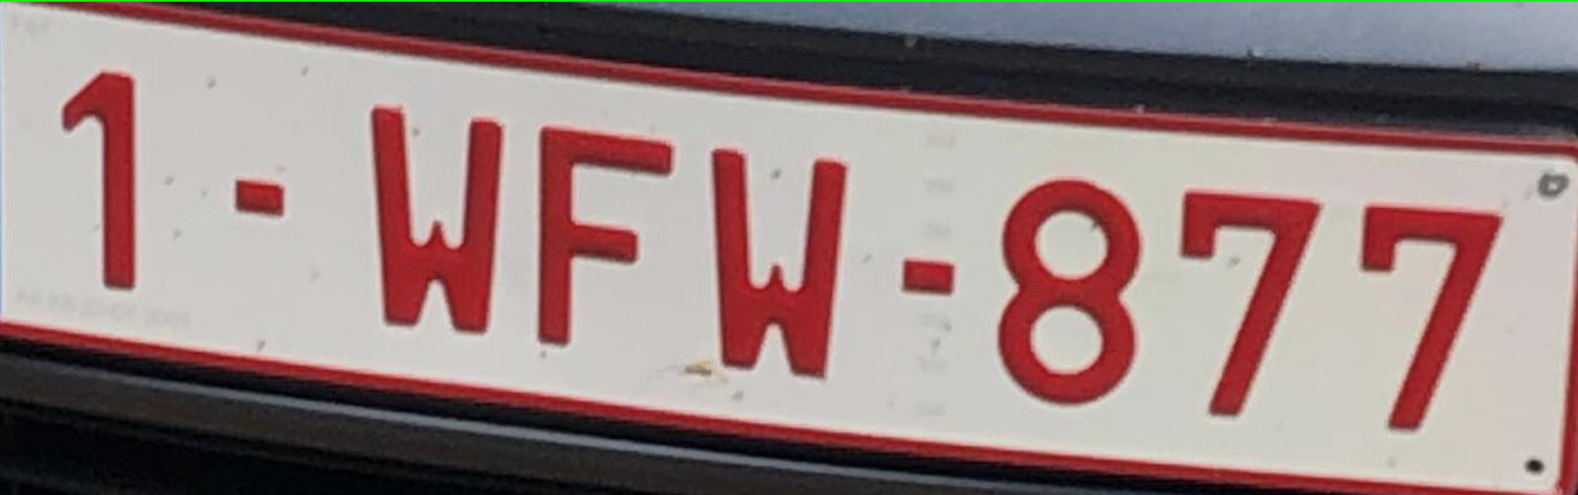

OpenCV字符分割，然後交由CNN訓練的模型做分類(classification)。

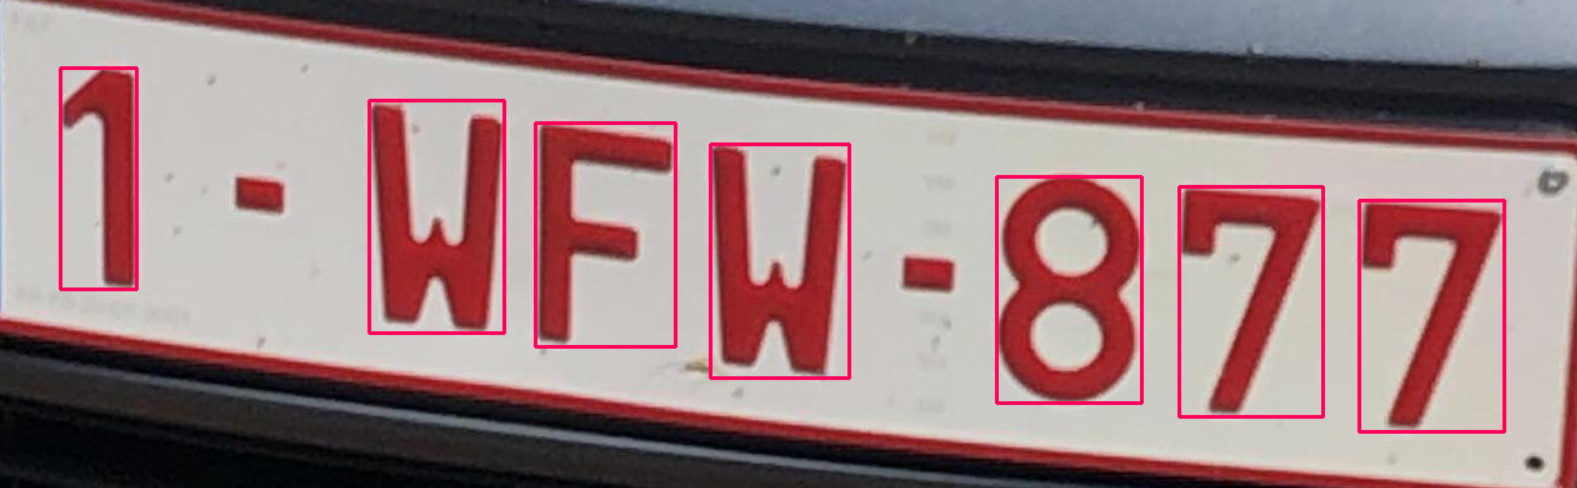